In [1]:


import numpy as np

import mne
mne.set_log_level(verbose='CRITICAL')
from mne.datasets import multimodal

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import tensorflow as tf
tf.get_logger().setLevel('ERROR')
tf.autograph.set_verbosity(0)

import mneflow



fname_raw = os.path.join(multimodal.data_path(), 'multimodal_raw.fif')
raw = mne.io.read_raw_fif(fname_raw)

cond = raw.acqparser.get_condition(raw, None)
# get the list of condition names
condition_names = [k for c in cond for k,v in c['event_id'].items()]
epochs_list = [mne.Epochs(raw, **c) for c in cond]
epochs = mne.concatenate_epochs(epochs_list)
epochs = epochs.pick_types(meg='grad')
# print(epochs.info)
print(tf.__version__)
import sys
current_dir = os.path.dirname(os.path.abspath('./'))
if not current_dir in sys.path:
    sys.path.append(current_dir)
from utils.data_management import *
# print(dict2str(vars(mneflow)))


2.7.0


In [2]:
#Specify import options
import_opt = dict(savepath='../tfr/',  # path where TFR files will be saved
                  out_name='mne_sample_epochs',  # name of TFRecords files
                  fs=600,
                  input_type='trials',
                  target_type='int',
                  picks={'meg':'grad'},
                  scale=True,  # apply baseline_scaling
                  crop_baseline=True,  # remove baseline interval after scaling
                  decimate=None,
                  scale_interval=(0, 60),  # indices in time axis corresponding to baseline interval
                  n_folds=5,  # validation set size set to 20% of all data
                  overwrite=True,
                  segment=False,
                  test_set='holdout')


#write TFRecord files and metadata file to disk
meta = mneflow.produce_tfrecords([epochs], **import_opt)  



processing epochs
input shapes: X- (940, 0, 361) targets- (940, 1)
Preprocessing:
Scaling to interval 0.0 - 60.0
Splitting sets
Preprocessed: (940, 1, 361, 0) (940, 8) folds: 6 x 156
Prepocessed sample shape: (1, 361, 0)
Target shape actual/metadata:  (8,) (8,)
Saving TFRecord# 0


/home/user/Projects/FingerMovementDecoder/venv/lib/python3.9/site-packages/mneflow/utils.py:81: RuntimeWarning: Mean of empty slice.
  X0m = X[..., interval].mean(axis=(1,2), keepdims=True)
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.9/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.9/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.9/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/user/Projects/FingerMovementDecoder/venv/lib/python3.9/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divid

In [3]:
dataset = mneflow.Dataset(meta, train_batch=100)

In [4]:
# specify model parameters
lf_params = dict(n_latent=32, #number of latent factors
                  filter_length=17, #convolutional filter length in time samples
                  nonlin = tf.nn.relu,
                  padding = 'SAME',
                  pooling = 5,#pooling factor
                  stride = 5, #stride parameter for pooling layer
                  pool_type='max',
                  model_path = import_opt['savepath'],
                  dropout = .5,
                  l1_scope = ["weights"],
                  l1=3e-3)

model = mneflow.models.LFCNN(dataset, lf_params)
model.build()

Setting reg for dmx, to l1
Built: dmx input: (None, 1, 361, 0)
Setting reg for tconv, to l1
Built: tconv input: (None, 1, 361, 32)
Setting reg for fc, to l1
Built: fc input: (None, 1, 73, 32)
Input shape: (1, 361, 0)
y_pred: (None, 8)
Initialization complete!


In [13]:
import sklearn
print(sklearn.__version__)

from importlib.metadata import version
print(f'mneflow: {version("mneflow")}')
print(f'matplotlib: {version("matplotlib")}')
print(f'mne: {version("mne")}')
print(f'numpy: {version("numpy")}')
print(f'scipy: {version("scipy")}')
print(f'sklearn: {sklearn.__version__}')
print(f'tensorflow: {version("tensorflow")}')

1.0.1
mneflow: 0.3.2
matplotlib: 3.5.1
mne: 0.24.1
numpy: 1.21.4
scipy: 1.7.3
sklearn: 1.0.1
tensorflow: 2.7.0


Epoch 1/25
100/100 - 3s - loss: 3.4868 - cat_ACC: 0.1288 - val_loss: 3.3544 - val_cat_ACC: 0.1371 - 3s/epoch - 26ms/step
Epoch 2/25
100/100 - 1s - loss: 3.2469 - cat_ACC: 0.1360 - val_loss: 3.1274 - val_cat_ACC: 0.1371 - 1s/epoch - 14ms/step
Epoch 3/25
100/100 - 1s - loss: 3.0334 - cat_ACC: 0.1358 - val_loss: 2.9258 - val_cat_ACC: 0.1371 - 1s/epoch - 14ms/step
Epoch 4/25
100/100 - 1s - loss: 2.8477 - cat_ACC: 0.1270 - val_loss: 2.7509 - val_cat_ACC: 0.1371 - 1s/epoch - 13ms/step
Epoch 5/25
100/100 - 1s - loss: 2.6794 - cat_ACC: 0.1360 - val_loss: 2.6040 - val_cat_ACC: 0.1371 - 1s/epoch - 13ms/step
Epoch 6/25
100/100 - 1s - loss: 2.5463 - cat_ACC: 0.1360 - val_loss: 2.4805 - val_cat_ACC: 0.1371 - 1s/epoch - 11ms/step
Epoch 7/25
100/100 - 1s - loss: 2.4384 - cat_ACC: 0.1270 - val_loss: 2.3815 - val_cat_ACC: 0.1371 - 1s/epoch - 12ms/step
Epoch 8/25
100/100 - 1s - loss: 2.3464 - cat_ACC: 0.1360 - val_loss: 2.3059 - val_cat_ACC: 0.1371 - 1s/epoch - 11ms/step
Epoch 9/25
100/100 - 1s - loss: 

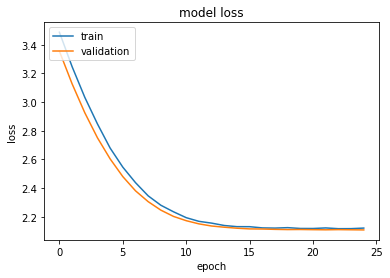

In [5]:
model.train(n_epochs=25, eval_step=100, early_stopping=5)
model.plot_hist()

In [6]:
model.compute_patterns()
f1 = model.plot_patterns('Vectorview-grad', sorting='output_corr')


Computing patterns: No path specified, using validation dataset (Default)


ValueError: Info (204) and data (0) must have same number of channels.